In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
ratings = pd.read_csv('u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movies = pd.read_csv('u.item', sep = "|", encoding='latin-1', usecols=[0, 1], names=['movieId', 'title'])

In [7]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
df = pd.merge(ratings,movies,on='movieId')
df.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [9]:
df[['userId','movieId','title']].to_csv(r"C:\Users\neelh\Jupyter Related\Recsys project\data\movie_data.csv", index=False)

In [10]:
movie_user_matrix = df.pivot_table(index='title',columns='userId',values='rating')
movie_user_matrix.fillna(0,inplace=True)



                                   

In [11]:
#reducing the dimensions using t-SNE to plot 
from sklearn.manifold import TSNE

#get the movie vector
movie_vectors = movie_user_matrix.values

#use tsne to reduce the dimensions of movie vectors to 2d
tsne = TSNE(n_components=2, random_state=42)

reduced_data = tsne.fit_transform(movie_vectors)

#create a dataframe for easy plotiing
reduced_df = pd.DataFrame(reduced_data,columns=['X','Y'])
reduced_df['movie'] = movie_user_matrix.index


In [12]:
print(reduced_df)

              X          Y                                  movie
0     -3.347515 -22.046722              'Til There Was You (1997)
1    -13.370107  14.876300                           1-900 (1994)
2      5.259487 -12.701149                  101 Dalmatians (1996)
3     -5.315996  28.976753                    12 Angry Men (1957)
4    -17.882381 -31.392183                             187 (1997)
...         ...        ...                                    ...
1659  27.775326  -2.479654                   Young Guns II (1990)
1660 -31.764250   6.939404  Young Poisoner's Handbook, The (1995)
1661  -3.176181 -10.540618                Zeus and Roxanne (1997)
1662   5.461266  -2.303857                                unknown
1663 -21.208292   5.386969     Á köldum klaka (Cold Fever) (1994)

[1664 rows x 3 columns]


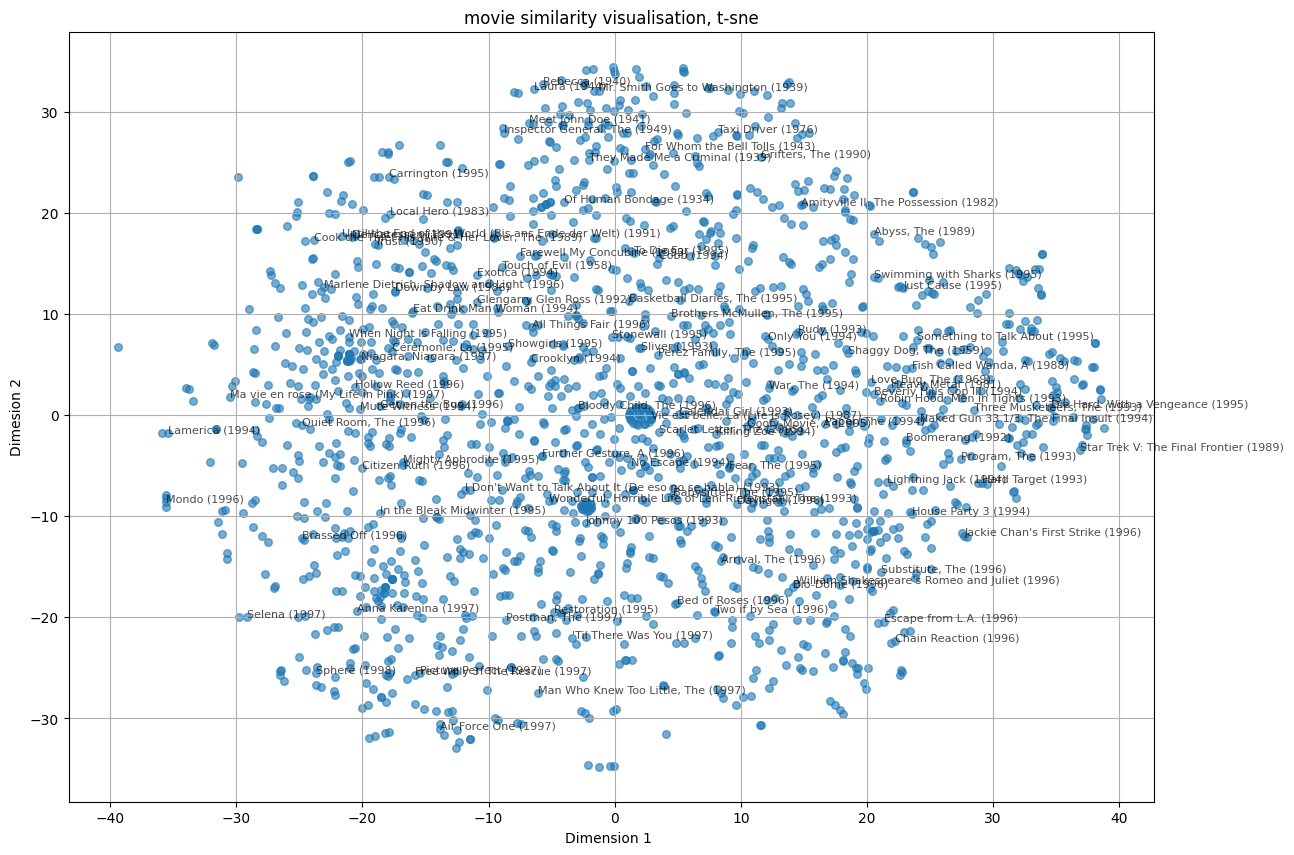

In [13]:
plt.figure(figsize=(14,10))
plt.scatter(reduced_df['X'],reduced_df['Y'],alpha=0.6, s=30)

#annotating a few popular movies to avoid clutter
for i in range(0,len(reduced_df), int(len(reduced_df)/100)):
    plt.annotate(reduced_df['movie'].iloc[i],(reduced_df['X'].iloc[i],reduced_df['Y'].iloc[i]),fontsize=8,alpha=0.7)

plt.title('movie similarity visualisation, t-sne')
plt.xlabel("Dimension 1 ")
plt.ylabel("Dimesion 2")
plt.grid(True)
plt.show()
    

In [14]:
from scipy.sparse import csr_matrix

In [15]:
movie_user_sparse = csr_matrix(movie_user_matrix.values)

In [16]:
#use the KNN
from sklearn.neighbors import NearestNeighbors
#initialise the knn model
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')

#fit the model on the parse matrix
model_knn.fit(movie_user_sparse)


NearestNeighbors(algorithm='brute', metric='cosine')

In [18]:
#get recommendation for the movie
#find the index
print("input the movie name")
movie_name = input(str('movie_name'))
movie_index = movie_user_matrix.index.get_loc(movie_name)

#get the top 6 nearest neighbors
distance,indices = model_knn.kneighbors(movie_user_matrix.iloc[movie_index,:].values.reshape(1,-1),n_neighbors=6)

input the movie name


movie_name Chain Reaction (1996)


In [19]:
# print top 5 recommendations
for i in range(1,6):
    print(f"{i}: {movie_user_matrix.index[indices[0][i]]}")

1: Dragonheart (1996)
2: Eraser (1996)
3: Twister (1996)
4: Escape from L.A. (1996)
5: Independence Day (ID4) (1996)


In [20]:
def hit_at_k(model_knn, movie_user_matrix, movie_user_sparse, k=5, num_samples=100):
    hits = 0 
    total = 0
    all_users = movie_user_matrix.columns
    all_movies = movie_user_matrix.index
    
    for _ in range(num_samples):
        # 1. Sample a (user,movie) pair where the rating exists
        movie = random.choice(all_movies)
        user_rating = movie_user_matrix.loc[movie]
        rated_users = user_rating[user_rating > 0].index
        if len(rated_users) == 0:
            continue  # Skip if no one rated this movie
            
        user = random.choice(rated_users)
        
        # 2. Store and hide the rating
        original_rating = movie_user_matrix.loc[movie, user]
        movie_user_matrix.loc[movie, user] = 0
        
        # 3. Get user's other rated movies (for seed selection)
        user_rated_movies = movie_user_matrix[movie_user_matrix[user] > 0].index
        
        if len(user_rated_movies) == 0:
            # Restore rating and skip - no context for recommendation
            movie_user_matrix.loc[movie, user] = original_rating
            continue
        
        # 4. Pick seed movie and get recommendations
        seed_movie = random.choice(user_rated_movies)
        seed_index = movie_user_matrix.index.get_loc(seed_movie)
        
        distances, indices = model_knn.kneighbors(
            movie_user_sparse[seed_index], n_neighbors=k+1
        )
        
        recommended_movies = [
            movie_user_matrix.index[i] for i in indices[0] 
            if movie_user_matrix.index[i] != seed_movie
        ][:k]
        
        # 5. Check if hidden movie is in recommendations
        if movie in recommended_movies:
            hits += 1
        total += 1
        
        # 6. Restore original rating
        movie_user_matrix.loc[movie, user] = original_rating
    
    hit_rate = hits / total if total > 0 else 0
    return hit_rate, hits, total

# Usage:
hit_rate, hits, total = hit_at_k(model_knn, movie_user_matrix, movie_user_sparse, k=5, num_samples=100)
print(f"Hit@{k}: {hit_rate:.3f} ({hits}/{total})")

NameError: name 'random' is not defined

# Using the SVD Method # 

In [21]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [22]:
#load the dataset
reader = Reader(rating_scale=(0.5,5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [23]:
trainset, testset = train_test_split(data, test_size=0.2)

In [24]:
model = SVD()

In [25]:
model.fit(trainset)

In [26]:
model.test(testset)

[Prediction(uid=235, iid=79, r_ui=4.0, est=3.85282785774463, details={'was_impossible': False}),
 Prediction(uid=523, iid=509, r_ui=4.0, est=4.693679701201026, details={'was_impossible': False}),
 Prediction(uid=234, iid=97, r_ui=2.0, est=3.1271777362100126, details={'was_impossible': False}),
 Prediction(uid=301, iid=94, r_ui=4.0, est=3.4792990222883375, details={'was_impossible': False}),
 Prediction(uid=393, iid=728, r_ui=3.0, est=3.1525820905518396, details={'was_impossible': False}),
 Prediction(uid=932, iid=607, r_ui=4.0, est=4.415858872508449, details={'was_impossible': False}),
 Prediction(uid=73, iid=48, r_ui=2.0, est=3.794991990812731, details={'was_impossible': False}),
 Prediction(uid=407, iid=229, r_ui=3.0, est=2.694285912347763, details={'was_impossible': False}),
 Prediction(uid=391, iid=435, r_ui=5.0, est=3.9862555449375745, details={'was_impossible': False}),
 Prediction(uid=308, iid=684, r_ui=3.0, est=3.5514631880064638, details={'was_impossible': False}),
 Prediction

In [27]:
predicta = model.test(testset)

prediction = model.predict(uid='1', iid='10')
print(prediction)

user: 1          item: 10         r_ui = None   est = 3.53   {'was_impossible': False}


In [28]:
from surprise import accuracy

# Calculate the RMSE on the test set
rmse = accuracy.rmse(predicta)
print(f'RMSE: {rmse}')

RMSE: 0.9420
RMSE: 0.9419685719145874


In [29]:
from surprise import BaselineOnly
from surprise.model_selection import cross_validate

model_base = BaselineOnly()
cross_validate(model_base, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9494  0.9380  0.9425  0.9433  0.9472  0.9441  0.0040  
Fit time          0.16    0.15    0.35    0.20    0.19    0.21    0.07    
Test time         0.53    0.15    0.15    0.12    0.29    0.25    0.15    


{'test_rmse': array([0.94938277, 0.93795082, 0.94254408, 0.94331436, 0.94722122]),
 'fit_time': (0.1646578311920166,
  0.15090274810791016,
  0.34604930877685547,
  0.1984107494354248,
  0.19300603866577148),
 'test_time': (0.5339004993438721,
  0.15101289749145508,
  0.14874863624572754,
  0.12465953826904297,
  0.2852158546447754)}

In [30]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import accuracy

# Load your data
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Define hyperparameter grid (keep it simple!)
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# One line to find best parameters!
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Get results
print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best params: {gs.best_params['rmse']}")

# Use the best model
best_svd = gs.best_estimator['rmse']



Best RMSE: 0.9212
Best params: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fake data
data = {
    'Movie': ['The Matrix', 'Inception', 'Titanic', 'Avatar', 'Joker', 'Barbie'],
    'User1': [5, 5, 2, 2, 3, 1],
    'User2': [4, 5, 1, 1, 4, 2],
    'User3': [5, 5, 2, 1, 3, 1],
    'User4': [4, 4, 2, 2, 4, 2],
    'User5': [5, 5, 1, 2, 3, 1],
}

df = pd.DataFrame(data)
features = df.drop('Movie', axis=1)

# === PCA ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# === t-SNE ===
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
tsne_result = tsne.fit_transform(features)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA
axs[0].scatter(pca_result[:, 0], pca_result[:, 1])
for i, movie in enumerate(df['Movie']):
    axs[0].annotate(movie, (pca_result[i, 0], pca_result[i, 1]))
axs[0].set_title('PCA: Movie Projection')

# t-SNE
axs[1].scatter(tsne_result[:, 0], tsne_result[:, 1])
for i, movie in enumerate(df['Movie']):
    axs[1].annotate(movie, (tsne_result[i, 0], tsne_result[i, 1]))
axs[1].set_title('t-SNE: Movie Projection')

plt.tight_layout()
plt.show()

In [ ]:
#let's make recommendations

all_movie_ids = df['movieId'].unique()

#step1 - get a list of movie ids
user_id = input("Enter user_id: ")

if user_id not in df['userId'].astype(str).unique(): #Add .astype(str) in userId check if your user IDs are stored as integers but you’re taking input as string.
    print("This user ID does not exist.")
else:
    predictions_for_user = [model.predict(uid=user_id, iid=movieId) for movieId in all_movie_ids]

    top_n_predictions = sorted(predictions_for_user, key=lambda x: x.est, reverse=True)[:10]

    movie_titles = dict(zip(movies['movieId'], movies['title']))

    for prediction in top_n_predictions:
        movie_title = movie_titles.get(int(prediction.iid), "Unknown movie")
        print(f"{movie_title}: {round(prediction.est, 2)}")

In [ ]:
import pickle

# Save your Surprise model (KNN, SVD, etc.)
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
import random

def get_top_k_recommendations(model, trainset, user_id, k=10):
    """
    Generate top-k movie recommendations for a specific user
    """
    # Get all movies
    all_movies = set([trainset.to_raw_iid(i) for i in trainset.all_items()])
    
    # Get movies already rated by this user
    user_movies = set([trainset.to_raw_iid(i) for (i, _) in trainset.ur[trainset.to_inner_uid(user_id)]])
    
    # Movies not yet rated by user
    unrated_movies = all_movies - user_movies
    
    # Predict ratings for all unrated movies
    predictions = []
    for movie_id in unrated_movies:
        pred = model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
    
    # Sort by predicted rating and get top-k
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k = [movie_id for movie_id, rating in predictions[:k]]
    
    return top_k

def svd_hit_at_k(ratings_df, k=5, num_samples=100):
    """
    Evaluate SVD using hit@k metric
    """
    hits = 0
    total = 0
    
    # Prepare data
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    
    # Sample test pairs (user, movie) where rating exists
    positive_ratings = ratings_df[ratings_df['rating'] >= 3.5]  # Only test on good ratings
    test_pairs = positive_ratings.sample(n=min(num_samples, len(positive_ratings)))
    
    for idx, row in test_pairs.iterrows():
        user_id = str(row['userId'])
        movie_id = str(row['movieId'])
        original_rating = row['rating']
        
        # Create dataset without this rating (hide it)
        temp_ratings = ratings_df.copy()
        temp_ratings = temp_ratings[~((temp_ratings['userId'] == int(user_id)) & 
                                   (temp_ratings['movieId'] == int(movie_id)))]
        
        # Check if user has enough other ratings for meaningful recommendations
        user_other_ratings = temp_ratings[temp_ratings['userId'] == int(user_id)]
        if len(user_other_ratings) < 3:  # Need at least 3 other ratings
            continue
            
        # Recreate dataset and train model
        temp_data = Dataset.load_from_df(temp_ratings[['userId', 'movieId', 'rating']], reader)
        trainset = temp_data.build_full_trainset()
        
        # Train SVD model
        model = SVD()
        model.fit(trainset)
        
        try:
            # Generate top-k recommendations for this user
            recommendations = get_top_k_recommendations(model, trainset, user_id, k)
            
            # Check if hidden movie is in recommendations
            if movie_id in recommendations:
                hits += 1
            total += 1
            
            # Print progress
            if total % 10 == 0:
                print(f"Processed {total} tests, current hit rate: {hits/total:.3f}")
                
        except Exception as e:
            print(f"Error processing user {user_id}, movie {movie_id}: {e}")
            continue
    
    hit_rate = hits / total if total > 0 else 0
    return hit_rate, hits, total

# Example usage:
"""
# Load your ratings data
ratings = pd.read_csv('your_ratings.csv')

# Run hit@k evaluation
hit_rate, hits, total = svd_hit_at_k(ratings, k=5, num_samples=50)
print(f"SVD Hit@{5}: {hit_rate:.3f} ({hits}/{total})")

# Compare with your KNN results
print(f"KNN Hit@{5}: [your KNN hit rate]")
print(f"SVD is {hit_rate/knn_hit_rate:.1f}x better than KNN")
"""